### Importing Needed packages


In [126]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import math
# from sklearn import linear_model
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
%matplotlib inline

### Downloading Data

In [127]:
!wget -O books2.csv https://raw.githubusercontent.com/heEXDe/some_machine_learning_jupyter_notebooks/main/books2.csv

--2021-02-19 19:24:11--  https://raw.githubusercontent.com/heEXDe/some_machine_learning_jupyter_notebooks/main/books2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1128651 (1,1M) [text/plain]
Saving to: ‘books2.csv’

books2.csv          100%[===================>]   1,08M  7,15MB/s    in 0,2s    

2021-02-19 19:24:11 (7,15 MB/s) - ‘books2.csv’ saved [1128651/1128651]



<h2 id="reading_data">Reading the data in</h2>


In [128]:
df = pd.read_csv("books2.csv")
df.head()

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


As we will be trying to develop a model to predict the average ratings scores for books, and because those scores can have non-integer values, our dependent values will be of the continuous nature.
Lets select some features that we want to use for regression.

In [129]:
cdf = df[['num_pages','ratings_count','text_reviews_count','average_rating']]
print(len(cdf))
cdf.head(10)

8471


,num_pages,ratings_count,text_reviews_count,average_rating
0,652,2095690,27591,4.57
1,870,2153167,29221,4.49
2,352,6333,244,4.42
3,435,2339585,36325,4.56
4,2690,41428,164,4.78
5,152,19,1,3.74
6,3342,28242,808,4.73
7,815,3628,254,4.38
8,815,249558,4080,4.38
9,215,4930,460,4.22


Lets we check if there is a linear correlationn between the independent and dependent daata - 'num_pages' and 'average_rating', 'ratings_count' and 'average_rating', 'text_reviews_count' and 'average_rating':


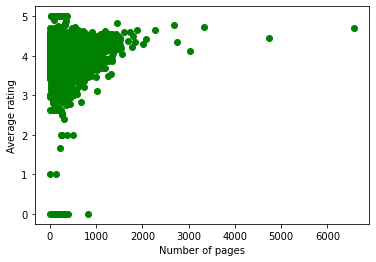

In [130]:
plt.scatter(cdf.num_pages, cdf.average_rating,  color='green')
plt.xlabel("Number of pages")
plt.ylabel("Average rating")
plt.show()

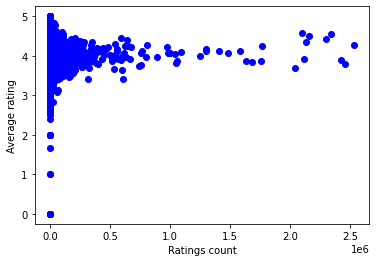

In [131]:
plt.scatter(cdf.ratings_count, cdf.average_rating,  color='blue')
plt.xlabel("Ratings count")
plt.ylabel("Average rating")
plt.show()

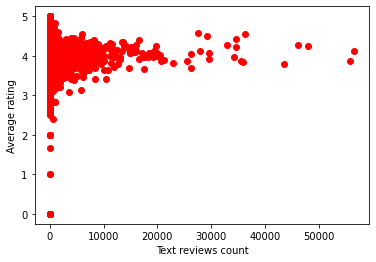

In [132]:
plt.scatter(cdf.text_reviews_count, cdf.average_rating,  color='red')
plt.xlabel("Text reviews count")
plt.ylabel("Average rating")
plt.show()

Splitting data into 'features' set and 'targets' set and setting the sizes of the train, test and evaluation sets.

In [133]:
features = cdf.drop(['average_rating'], axis = 1)
# print(features['num_pages'].unique())
targets = cdf.iloc[:, -1]
# print(targets.unique())
train_size = int((.8 * len(cdf))) # 80% of dataset for training; '-1' because of teh use of the 'ceil' method below
val_size = int(math.ceil(.1 * len(cdf)))  # 10% for validation
test_size = int(math.floor((.1 * len(cdf)))) # 10% for testing

Spliting data according to the sizes.

In [134]:
dataset = TensorDataset(torch.Tensor(np.array(features)).float(), torch.Tensor(targets).long()) # numpy arrays to torch tensors
train_ds, val_ds, test_ds = random_split(cdf, [train_size, val_size, test_size])

Setting the batch size and preparing data loaders.

In [135]:
batch_size = 100
train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size, shuffle = True)
test_loader = DataLoader(test_ds, batch_size, shuffle = True)

In [136]:
input_size = len(cdf.columns) - 1
print(input_size)
output_size = len(targets.unique())
print(output_size)
# threshold = .5

3
201


Declaring the model calss.

In [137]:
class BooksModel(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 80),
    self.relu1 = nn.ReLU(),
    self.linear2 = nn.Linear(80, 150),
    self.relu2 = nn.ReLU(),
    self.linear3 = nn.Linear(150, output_size)
  
  def forward(self, xb):
    out = self.linear1(xb)
    out = self.relu1(out)
    out = self.linear2(out)
    out = self.relu2(out)
    out = self.linear3(out)
    return out

Model initiation.

In [138]:
model = BooksModel()

Training. First - calculating number of epochs.

In [139]:
n_iters = 8000
num_epochs = n_iters / (len(train_ds) / batch_size)
num_epochs = int(num_epochs)
print(len(train_ds))
print('num_epochs:', num_epochs)

6776
num_epochs: 118


In [140]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

Process of training:

In [141]:
"""
for epoch in range(num_epochs):
  for i, (x, y) in enumerate(train_loader):
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  for z, (r, w) in enumerate(val_loader):
    outputs = model(r)
    loss = criterion(outputs, w)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
"""

def fit(num_epochs, model, loss_fn, opt, train_dl):
    
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        # Train with batches of data
        print(epoch)
        for xb,yb in train_loader:
            # 1. Generate predictions
            print(xb)
            pred = model(xb)
            # 2. Calculate loss
            loss = criterion(pred, yb)
            # 3. Compute gradients
            loss.backward()
            # 4. Update parameters using gradients
            optimizer.step()
            # 5. Reset the gradients to zero
            optimizer.zero_grad()

        # Print the progress
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

fit(num_epochs, model, criterion, optimizer, train_loader)

0


KeyError: 2201